In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


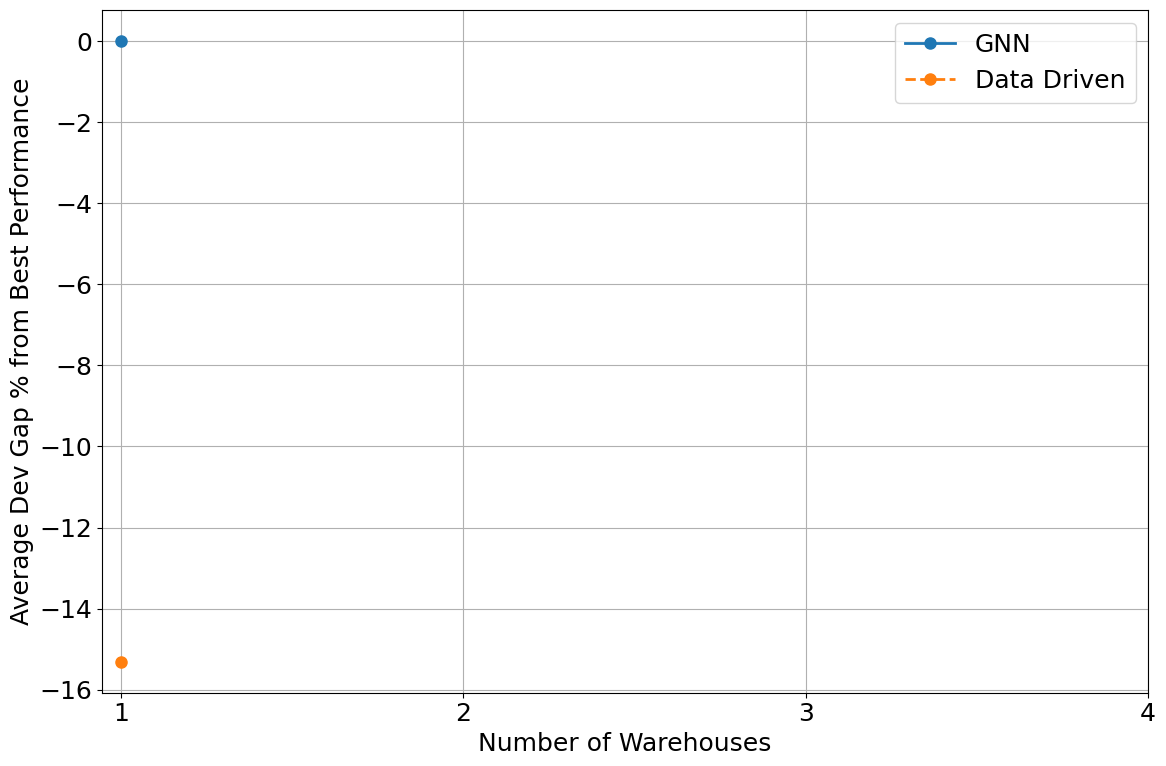

In [9]:
# Create vanilla results dataframe from the provided data
testset_names = ["n_warehouse_46_1_real"]#, "n_warehouse_46_2_real", "n_warehouse_46_3_real", "n_warehouse_46_4_real"]

results_interpretor = rri.RayResultsinterpreter()

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

# Define color scheme and line styles
color_scheme = {
    "GNN": "#1f77b4",    # Blue
    "Data Driven": "#ff7f0e"   # Orange
}

linestyle_scheme = {
    "GNN": "-",               # Solid
    "Data Driven": "--"       # Dashed
}

# Define paths for each architecture
architectures = {
    "GNN": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/GNN_real',
    "Data Driven": lambda testset: f'/user/ml4723/Prj/NIC/ray_results/{testset}/data_driven_net_n_warehouses_real'
}

sort_by = 'train_loss'
pick_row_from_run_by = 'train_loss'

dfs = []

# Create dataframes for each architecture and testset
for arch_name, path_fn in architectures.items():
    for testset_name in testset_names:
        path = path_fn(testset_name)
        n_warehouses = int(testset_name.split('_')[3])  # Extract warehouse number from testset name
        
        df = results_interpretor.make_table({1: path},
            {'samples': [1]},
            default_condition_setter, custom_data_filler,
            sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by,
            test_loss_limit = 100)
        if df.empty:
            continue
        
        df.insert(2, 'Architecture Class', arch_name)
        df.insert(1, 'hyperparam_name', arch_name)
        df['n_warehouses'] = n_warehouses
        dfs.append(df)

# Combine all dataframes
df = pd.concat(dfs, ignore_index=True)

# Calculate gap percentage using best performing loss for each warehouse count
stats_by_arch_and_warehouses = {}
for n_warehouses in range(1, 5):  # 1 to 4 warehouses
    warehouse_data = df[df['n_warehouses'] == n_warehouses].copy()
    if warehouse_data.empty:
        continue
    best_dev_loss = warehouse_data['Dev Loss'].min()
    warehouse_data.loc[:, 'Gap %'] = abs((warehouse_data['Dev Loss'] - best_dev_loss) / best_dev_loss) * 100
    
    for arch in warehouse_data['Architecture Class'].unique():
        key = arch
        if key not in stats_by_arch_and_warehouses:
            stats_by_arch_and_warehouses[key] = []
            
        arch_data = warehouse_data[warehouse_data['Architecture Class'] == arch]
        if not arch_data.empty:
            gaps = arch_data['Gap %'].to_numpy()
            mean_gap = np.mean(gaps)
            std_gap = np.std(gaps)
            ci_95 = 1.96 * std_gap / np.sqrt(len(gaps))
            stats_by_arch_and_warehouses[key].append({
                'n_warehouses': n_warehouses,
                'mean_gap': mean_gap,
                'ci_lower': mean_gap - ci_95,
                'ci_upper': mean_gap + ci_95
            })

# Create plot
FONTSIZE = 18
plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size': FONTSIZE})

# Plot lines
for arch, stats in stats_by_arch_and_warehouses.items():
    stats_df = pd.DataFrame(stats)
    if not stats_df.empty:
        warehouses_array = stats_df['n_warehouses'].to_numpy()
        mean_gap_array = stats_df['mean_gap'].to_numpy()
        ci_lower_array = stats_df['ci_lower'].to_numpy()
        ci_upper_array = stats_df['ci_upper'].to_numpy()
        
        plt.plot(warehouses_array, mean_gap_array,
                color=color_scheme[arch],
                linestyle=linestyle_scheme[arch],
                linewidth=2,
                marker='o',
                markersize=8,
                label=arch)
        
        plt.fill_between(warehouses_array,
                        ci_lower_array,
                        ci_upper_array,
                        color=color_scheme[arch],
                        alpha=0.1)

plt.xlabel('Number of Warehouses', fontsize=FONTSIZE)
plt.ylabel('Average Dev Gap % from Best Performance', fontsize=FONTSIZE)
plt.grid(True)
plt.legend(fontsize=FONTSIZE)

plt.xticks(range(1, 5), fontsize=FONTSIZE)
plt.yticks(fontsize=FONTSIZE)
plt.tight_layout()
plt.show()

In [7]:
df

,# of stores,hyperparam_name,samples,Architecture Class,Learning Rate,Train Loss,Dev Loss,# of runs,path,n_warehouses
0,1,GNN,1,GNN,0.001,-693.217212,-605.340623,6,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,1
1,1,Data Driven,1,Data Driven,0.001,-695.757371,-512.675849,5,/user/ml4723/Prj/NIC/ray_results/n_warehouse_4...,1
